In [1]:
%pip install gensim --upgrade
%pip install keras --upgrade 
%pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


We have retrieved data of US 2020 election with hashtag of Donald Trump and Joe Biden from Kaggle (https://www.kaggle.com/manchunhui/us-election-2020-tweets). It contains almost 900000 tweets related to Donal Trump and 700000 tweets related to Joe Biden. Secondly to train our model we have retrieved labeled data with sentiments from Kaggle (https://www.kaggle.com/kazanova/sentiment140 ), It contains 1.6 million tweets annotated with sentiments.

In [2]:
import os ; 

for dirname , _ , filenames in os.walk(r'C:\Git\DSC_proj\Data_Science_Project\Data'): 
  for filename in filenames:
    print(os.path.join(dirname , filename)) ; 
    


C:\Git\DSC_proj\Data_Science_Project\Data\desktop.ini
C:\Git\DSC_proj\Data_Science_Project\Data\sentiment140\training.1600000.processed.noemoticon.csv
C:\Git\DSC_proj\Data_Science_Project\Data\us-election-2020-tweets\hashtag_donaldtrump.csv
C:\Git\DSC_proj\Data_Science_Project\Data\us-election-2020-tweets\hashtag_joebiden.csv


In [150]:
import numpy as np
import pandas as pd

#NLP Library
import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2

from sklearn.random_projection import SparseRandomProjection

import time

# Data Preparation

Data Cleansing and Data Transformation



In [4]:
nlp = spacy.load("en_core_web_sm",disable=["tagger","parser","ner"])


# Preprocessing


Clean Tweets Using Regex

In it we removed some special characters and words that did not add any value in the sentiments of tweets but reduced processing time



In [5]:
def clean_tweet_text_regex(tweet): 
  
  tweet = tweet.lower() ; 
  
  tweet = re.sub(r"@[A-Za-z0-9]+","", tweet) # we are removing @Mentions from the tweets  
  
  tweet = re.sub(r"#","", tweet) # remove # \ART[\s]+
  
  tweet = re.sub(r"\ART[\s]+","", tweet) # Remove RT in start 
  tweet = re.sub(r"https?:\/\/\S+","", tweet) # Remove hyperlink
  tweet = re.sub("(.)\\1{2,}","\\1", tweet) # Remove more than one characters.
  tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet)) #remove special characters "!"
  
  
  return tweet


Clean Tweets using spacy . 

Clean Tweets Using Spacy
We have used Spacy to remove stopwords and lemmatization. Since there are a very huge number of tweets in each dataset, we have created the nlp document in chunks and then split it into spans. Now we have used spans to remove the stopwords and replace the lemma word

In [6]:
def clean_tweet_spacy_core(doc): 
  tokens = [] ; 
  
  for token in doc: 
    if token.is_stop: # removing the stop words 
      continue ; 
    
    if token.text != token.lemma_:   # root meaning 
      tokens.append(token.lemma_) ; 
    else:
      tokens.append(token.text) ;  
      
  tweet = " ".join(tokens) ; 
  
  return tweet ; 

  
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = nlp(' ||| '.join(list_of_texts))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    all_docs = None
    return new_docs 

def get_complete_spans(data,colname):
    splitted_frames = np.array_split(data, 500)
    docs=[]
    i = 1
    for frame in splitted_frames:
        docs.append(doc_to_spans(frame[colname]))
    return docs



def clean_tweet_spacy(data, colname):
    docs = get_complete_spans(data, colname)
    
    print("Tweets cleaning started")
    tweets = []
    
    for doces in docs:
        for doc in doces:
            tweets.append(clean_tweet_spacy_core(doc))

    print("Tweets cleanned")
    return tweets


# Detecting Language
Now we have used https://pypi.org/project/pycld2/ library to detect the languages of tweets. We have only used English tweets in this project to analyze the sentiments.

In [7]:
def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"

In [8]:
labeled_data = pd.read_csv(r"../Data_Science_Project/Data/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")

In [9]:
labeled_data.head()


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
labeled_data.columns = ["label", "time", "date", "query", "username", "text"] # we add the columns for the labelled data as its not present in the csv file . 


In [11]:
labeled_data.head()


,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [12]:
def check_columns_null_values(data): 
  column_null_values = pd.DataFrame(columns=["column" , "nullvalues"]) ; 
  
  null_values = [] ; 
  
  for column in data.columns:
    sum = data[column].isnull().sum() ; 
    
    print(f"{column}: null percent: {sum/data.shape[0]*100} null values: {sum}/{data.shape[0]} value count: {data.shape[0] - sum}/{data.shape[0]}") ; 
    
    null_values.append(sum) ; 
    
  column_null_values["column"] = data.columns ; 
  column_null_values["nullvalues"] = null_values ;  
  
  return column_null_values ; 


In [13]:
x = check_columns_null_values(labeled_data) ; 


label: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
time: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
date: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
query: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
username: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
text: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999


In [14]:
labeled_data["text"] = labeled_data["text"].apply(clean_tweet_text_regex)


In [15]:
train_langs = labeled_data["text"].apply(detect_lang)

print(train_langs);  # most are in english text only . 

0          ENGLISH
1          ENGLISH
2          ENGLISH
3          ENGLISH
4          ENGLISH
            ...   
1599994    ENGLISH
1599995    ENGLISH
1599996    ENGLISH
1599997    ENGLISH
1599998    ENGLISH
Name: text, Length: 1599999, dtype: object


In [16]:
train_langs.value_counts()


text
ENGLISH        1517046
Unknown          74024
SCOTS             2179
INDONESIAN        1034
PORTUGUESE         825
                ...   
ICELANDIC            2
AZERBAIJANI          1
SHONA                1
FIJIAN               1
SANGO                1
Name: count, Length: 105, dtype: int64

In [17]:
labeled_data['Lang'] = train_langs ; 

In [18]:
english_train_data = labeled_data[labeled_data['Lang'] == 'ENGLISH'] ; 

new_train_langs = english_train_data["text"].apply(detect_lang) ; 

print(new_train_langs.value_counts())  ; # now all are english texts only . 

text
ENGLISH    1517046
Name: count, dtype: int64


In [19]:
print(len(new_train_langs)) ; 

1517046


In [20]:
english_train_data['text'] = clean_tweet_spacy(english_train_data , 'text') ; 

c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\1389718115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_train_data['text'] = clean_tweet_spacy(english_train_data , 'text') ;


In [21]:
if (np.sum(labeled_data['text'].isnull())) > 0 : 
  labeled_data = labeled_data.dropna(subset=['text']) ; 
  

In [22]:
trump_tweets = pd.read_csv(r"../Data_Science_Project/Data/us-election-2020-tweets/hashtag_donaldtrump.csv", engine="python")
trump_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529227471237e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.28355589206057e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [23]:
trump_tweets.columns


Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')

In [24]:
columns = ['tweet', 'created_at', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'user_location', 'lat','long', 'city', 'country', 'continent', 'state', 'state_code']

trump_tweets = trump_tweets[columns] ; 

print(trump_tweets.head()) ;  

                                               tweet           created_at  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...  2020-10-15 00:00:01   
1  Usa 2020, Trump contro Facebook e Twitter: cop...  2020-10-15 00:00:01   
2  #Trump: As a student I used to hear for years,...  2020-10-15 00:00:02   
3  2 hours since last tweet from #Trump! Maybe he...  2020-10-15 00:00:02   
4  You get a tie! And you get a tie! #Trump ‘s ra...  2020-10-15 00:00:08   

  likes  retweet_count               user_id user_followers_count  \
0   0.0            0.0           360666534.0               1860.0   
1  26.0            9.0           331617619.0            1067661.0   
2   2.0            1.0             8436472.0               1185.0   
3   0.0            0.0  8.28355589206057e+17                 32.0   
4   4.0            3.0            47413798.0               5393.0   

                  user_location         lat          long        city  \
0  Philadelphia, PA / Miami, FL    25.77427     -

In [25]:
col_null_values = check_columns_null_values(trump_tweets) ; 

tweet: null percent: 0.0014416833919103026 null values: 14/971087 value count: 971073/971087
created_at: null percent: 0.0 null values: 0/971087 value count: 971087/971087
likes: null percent: 0.004325050175730908 null values: 42/971087 value count: 971045/971087
retweet_count: null percent: 0.01585851731101333 null values: 154/971087 value count: 970933/971087
user_id: null percent: 0.016270426851559126 null values: 158/971087 value count: 970929/971087
user_followers_count: null percent: 0.017506155473196533 null values: 170/971087 value count: 970917/971087
user_location: null percent: 30.40479380323287 null values: 295257/971087 value count: 675830/971087
lat: null percent: 54.10277348991388 null values: 525385/971087 value count: 445702/971087
long: null percent: 54.102464557758466 null values: 525382/971087 value count: 445705/971087
city: null percent: 76.60559764470125 null values: 743907/971087 value count: 227180/971087
country: null percent: 54.40861632376913 null values: 52

Text(0.5, 1.0, 'Null Values in Donald Trump Dataset')

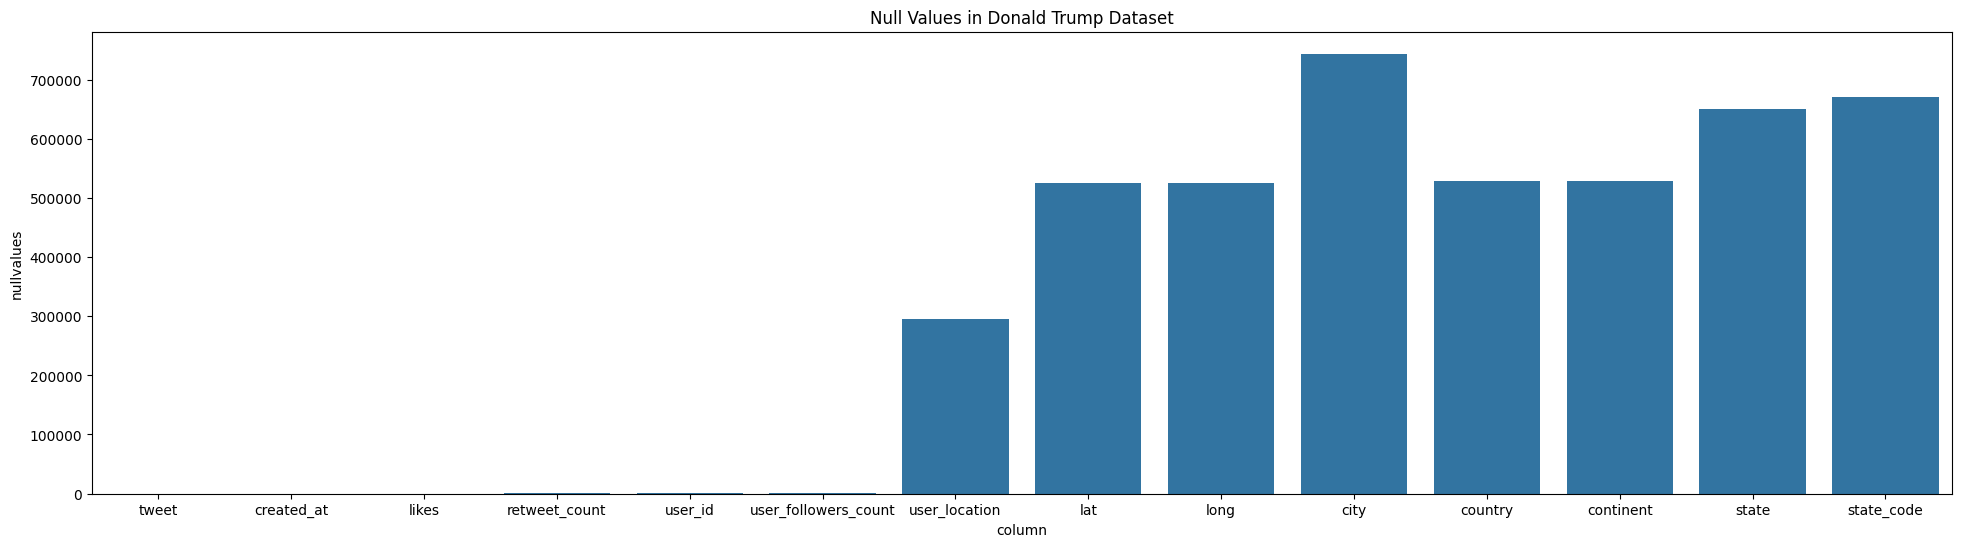

In [26]:
plt.figure(figsize=(24 , 6)) ; 

snb.barplot(x=col_null_values['column'] , y=col_null_values['nullvalues']) ; 

plt.title("Null Values in Donald Trump Dataset")


In [27]:
trump_tweets.dtypes


tweet                    object
created_at               object
likes                    object
retweet_count           float64
user_id                  object
user_followers_count     object
user_location            object
lat                      object
long                     object
city                     object
country                  object
continent                object
state                    object
state_code               object
dtype: object

In [28]:
def clean_data_frame(dataframe): 
  dataframe['likes'] = pd.to_numeric(dataframe['likes'] , errors='coerce') ; 
  
  dataframe['user_followers_count'] = pd.to_numeric(dataframe['user_followers_count'] , errors='coerce') ; 
  
  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ; 

  dataframe["retweet_count"].fillna(dataframe["retweet_count"].mean(), inplace=True)

  dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors="coerce") 
  
  dataframe["created_at"] = dataframe["created_at"].dt.strftime('%m-%d')
  
  



In [29]:
clean_data_frame(trump_tweets)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\940605279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ;
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\940605279.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [30]:
np.sum(trump_tweets["tweet"].isnull())


14

In [31]:
trump_tweets = trump_tweets.dropna(subset=['tweet'])


In [32]:
check_columns_null_values(trump_tweets) ; 


tweet: null percent: 0.0 null values: 0/971073 value count: 971073/971073
created_at: null percent: 0.015858745943919766 null values: 154/971073 value count: 970919/971073
likes: null percent: 0.0 null values: 0/971073 value count: 971073/971073
retweet_count: null percent: 0.0 null values: 0/971073 value count: 971073/971073
user_id: null percent: 0.014828957246262639 null values: 144/971073 value count: 970929/971073
user_followers_count: null percent: 0.031202597539010973 null values: 303/971073 value count: 970770/971073
user_location: null percent: 30.40379044623834 null values: 295243/971073 value count: 675830/971073
lat: null percent: 54.10211178768228 null values: 525371/971073 value count: 445702/971073
long: null percent: 54.10180285107299 null values: 525368/971073 value count: 445705/971073
city: null percent: 76.60526036662537 null values: 743893/971073 value count: 227180/971073
country: null percent: 54.40795903088645 null values: 528341/971073 value count: 442732/97107

In [33]:
trump_tweets['tweet'] = trump_tweets['tweet'].apply(clean_tweet_text_regex) ;  


In [34]:
trump_langs = trump_tweets["tweet"].apply(detect_lang)


In [35]:
print(trump_langs.value_counts())  ; 


tweet
ENGLISH     673207
Unknown     127332
SPANISH      41265
GERMAN       37115
FRENCH       31466
             ...  
IGBO             1
YORUBA           1
MALAGASY         1
FIJIAN           1
SAMOAN           1
Name: count, Length: 101, dtype: int64


In [36]:
trump_tweets["Lang"] = trump_langs ; 


In [37]:
eng_tweet_trump = trump_tweets[trump_tweets["Lang"] == "ENGLISH"]


In [38]:
eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3983773141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")


In [39]:
joebiden_tweets = pd.read_csv("../Data_Science_Project/Data/us-election-2020-tweets/hashtag_joebiden.csv", engine="python")

joebiden_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.31652929585929e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.3165293050069524e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3494182277.0,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.3040364,-109.17143119999999,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.3165293080815575e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596012018524e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529312741253e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032806955356545e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.7014631,-118.75599740000001,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [40]:
joebiden_tweets = joebiden_tweets[columns] ; 


In [41]:
joe_col_null_values = check_columns_null_values(joebiden_tweets ) ; 


tweet: null percent: 0.010037666988815723 null values: 78/777073 value count: 776995/777073
created_at: null percent: 0.0 null values: 0/777073 value count: 777073/777073
likes: null percent: 0.020461398092585896 null values: 159/777073 value count: 776914/777073
retweet_count: null percent: 0.022906470820630753 null values: 178/777073 value count: 776895/777073
user_id: null percent: 0.023678599050539654 null values: 184/777073 value count: 776889/777073
user_followers_count: null percent: 0.024193351203812254 null values: 188/777073 value count: 776885/777073
user_location: null percent: 30.11428784683035 null values: 234010/777073 value count: 543063/777073
lat: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
long: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
city: null percent: 75.95219496752557 null values: 590204/777073 value count: 186869/777073
country: null percent: 54.47403268418797 null values: 

Text(0.5, 1.0, 'Null Values in Joe Biden Dataset')

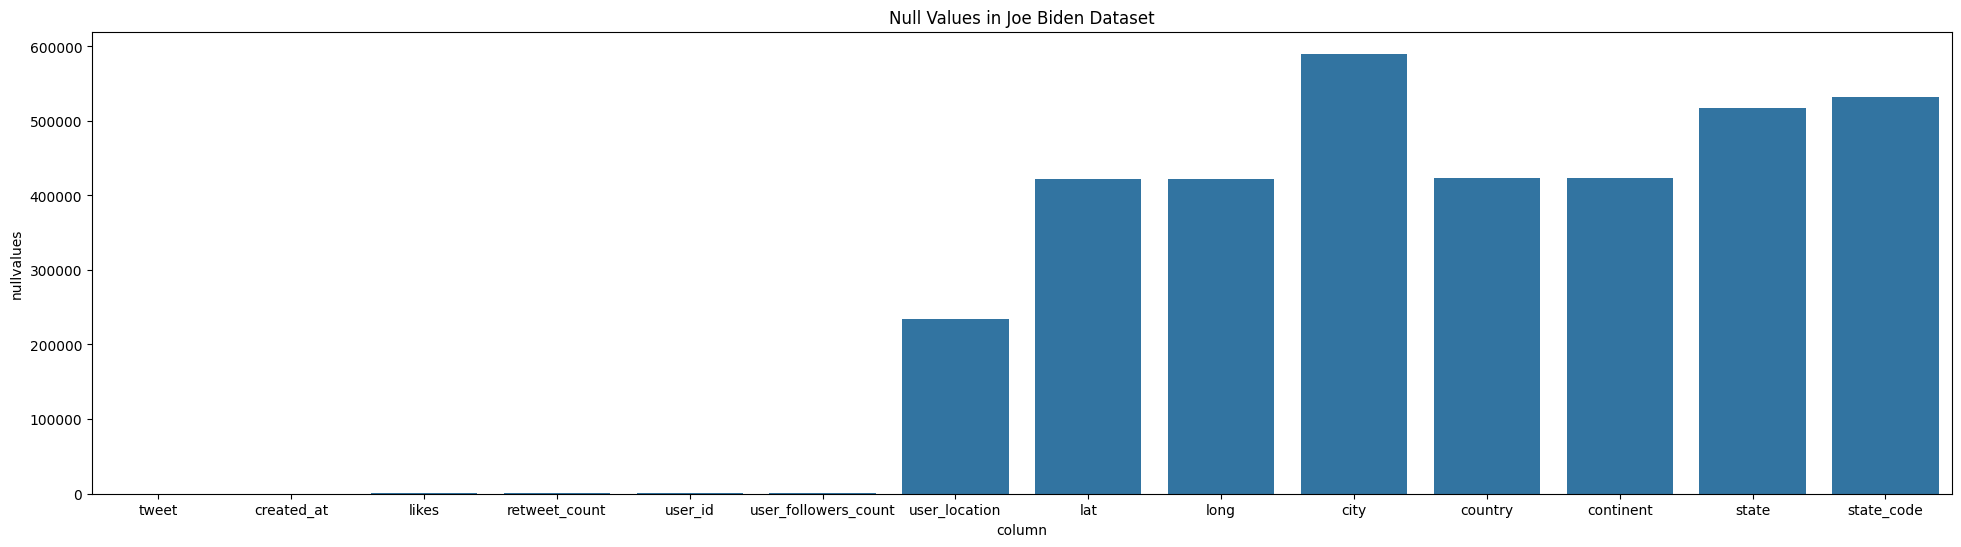

In [42]:
plt.figure(figsize=(24,6))

snb.barplot(x=joe_col_null_values["column"], y=joe_col_null_values["nullvalues"])
plt.title("Null Values in Joe Biden Dataset")

In [43]:
clean_data_frame(joebiden_tweets)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\940605279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ;
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\940605279.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [44]:
np.sum(joebiden_tweets["tweet"].isnull())


78

In [45]:
joebiden_tweets = joebiden_tweets.dropna(subset=['tweet'])


In [46]:
joebiden_tweets["tweet"] = joebiden_tweets["tweet"].apply(clean_tweet_text_regex)


In [47]:
joe_langs = joebiden_tweets["tweet"].apply(detect_lang)


In [48]:
joe_langs.unique()


array(['SPANISH', 'Unknown', 'ENGLISH', 'BASQUE', 'TURKISH', 'LATIN',
       'BRETON', 'GERMAN', 'FRENCH', 'XHOSA', 'INDONESIAN', 'CATALAN',
       'POLISH', 'DUTCH', 'PORTUGUESE', 'ITALIAN', 'SWEDISH', 'SCOTS',
       'FINNISH', 'CROATIAN', 'NORWEGIAN', 'AFRIKAANS', 'LUXEMBOURGISH',
       'KINYARWANDA', 'ALBANIAN', 'X_PIG_LATIN', 'CZECH', 'DANISH',
       'BOSNIAN', 'MALAY', 'HUNGARIAN', 'NORWEGIAN_N', 'GALICIAN',
       'VOLAPUK', 'RUNDI', 'IRISH', 'CORSICAN', 'NAURU', 'ROMANIAN',
       'INTERLINGUA', 'BISLAMA', 'SERBIAN', 'NDEBELE', 'SHONA',
       'SANSKRIT', 'X_KLINGON', 'INTERLINGUE', 'SESOTHO', 'GUARANI',
       'SOMALI', 'ESPERANTO', 'TSWANA', 'HAITIAN_CREOLE', 'SWAHILI',
       'SISWANT', 'LINGALA', 'RHAETO_ROMANCE', 'GANDA', 'NYANJA',
       'OCCITAN', 'SLOVENIAN', 'HAUSA', 'MALAGASY', 'TATAR', 'FAROESE',
       'UZBEK', 'AZERBAIJANI', 'FRISIAN', 'ESTONIAN', 'SLOVAK',
       'MAURITIAN_CREOLE', 'LATVIAN', 'SAMOAN', 'VIETNAMESE', 'SESELWA',
       'HAWAIIAN', 'CEBUANO', 'TAG

In [49]:
joe_langs.value_counts()


tweet
ENGLISH             526887
Unknown             118989
SPANISH              32578
FRENCH               22488
GERMAN               19271
                     ...  
X_KLINGON                1
NYANJA                   1
VIETNAMESE               1
MAURITIAN_CREOLE         1
SUNDANESE                1
Name: count, Length: 100, dtype: int64

In [50]:
joebiden_tweets["Lang"] = joe_langs


In [51]:
eng_joebiden_tweets = joebiden_tweets[joebiden_tweets["Lang"] == "ENGLISH"]


In [52]:
eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\2394210083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")


# Exploratory Data Analysis

Analyzed Top 10 Languages in All Datasets

We have only used English tweets in this project to analyze the sentiments.



In [53]:
train_lang = labeled_data["Lang"].value_counts() ; 

print(train_lang) ; 

Lang
ENGLISH        1517046
Unknown          74024
SCOTS             2179
INDONESIAN        1034
PORTUGUESE         825
                ...   
ICELANDIC            2
AZERBAIJANI          1
SHONA                1
FIJIAN               1
SANGO                1
Name: count, Length: 105, dtype: int64


In [54]:
trump_langs_value_count = trump_langs.value_counts() ; 

print(trump_langs_value_count) ; 

tweet
ENGLISH     673207
Unknown     127332
SPANISH      41265
GERMAN       37115
FRENCH       31466
             ...  
IGBO             1
YORUBA           1
MALAGASY         1
FIJIAN           1
SAMOAN           1
Name: count, Length: 101, dtype: int64


In [55]:
jeo_lang_count = joe_langs.value_counts()
print(jeo_lang_count)

tweet
ENGLISH             526887
Unknown             118989
SPANISH              32578
FRENCH               22488
GERMAN               19271
                     ...  
X_KLINGON                1
NYANJA                   1
VIETNAMESE               1
MAURITIAN_CREOLE         1
SUNDANESE                1
Name: count, Length: 100, dtype: int64


<Axes: title={'center': 'Joe Biden Data Top Ten Languages Count'}, xlabel='Languages', ylabel='Count'>

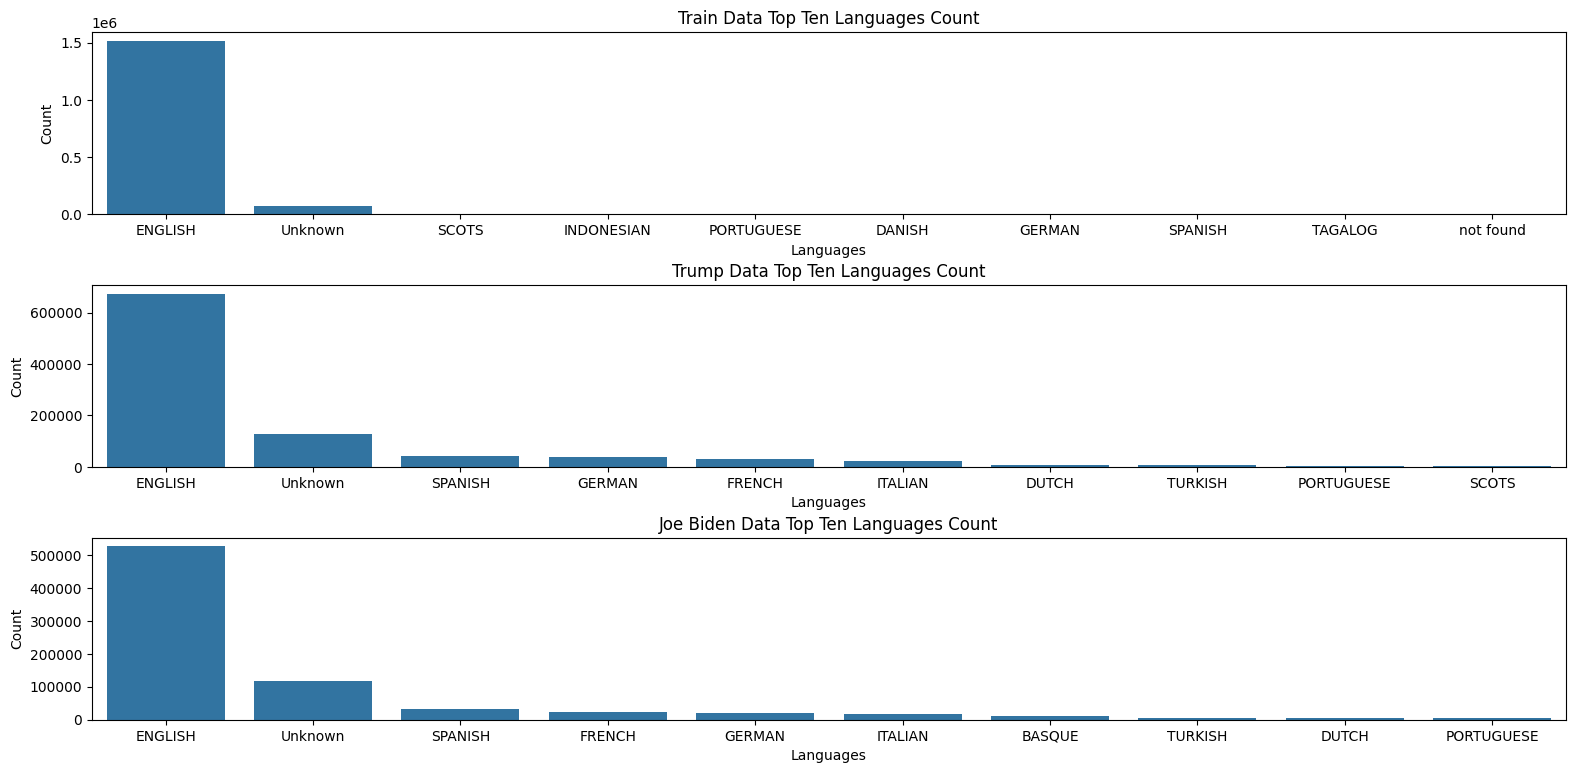

In [56]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 8))

fig.tight_layout(pad=3.0)
plt.setp(axes, xlabel="Languages", ylabel="Count")
axes[0].set_title("Train Data Top Ten Languages Count")
axes[1].set_title("Trump Data Top Ten Languages Count")
axes[2].set_title("Joe Biden Data Top Ten Languages Count")
snb.barplot(x=train_lang.index[:10], y=train_lang.values[:10], ax=axes[0])

snb.barplot(x=trump_langs_value_count.index[:10], y=trump_langs_value_count.values[:10], ax=axes[1])

snb.barplot(x=jeo_lang_count.index[:10], y=jeo_lang_count.values[:10], ax=axes[2])

Analyzed Tweets, Likes and Retweets Count w.r.t. Date . 


First we have analyzed the count of tweets and likes for both the participants w.r.t. Date and according to graph Joe Biden Graph is increasing by time . 

Now we have analyzed the count of retweets for both the participants w.r.t. Date and according to the graph Donald Trump retweets count is increasing by time.

In [57]:
trump_tweets_by_date = trump_tweets.groupby("created_at") ; 

trump_tweets_count_by_date = trump_tweets_by_date.count() ; 

trump_tweets_by_date_sum = trump_tweets_by_date.sum(numeric_only=True)


In [58]:
joe_tweets_by_date = joebiden_tweets.groupby("created_at")

joe_tweets_count_by_date = joe_tweets_by_date.count()

joe_tweets_by_date_sum = joe_tweets_by_date.sum(numeric_only=True)

In [59]:
overall_df = pd.DataFrame(columns=['Date' , 'Trump Tweet Count', 'Joe Biden Tweet Count']) ; 
overall_df["Date"] = trump_tweets_count_by_date.index
overall_df["Trump Tweet Count"] = list(trump_tweets_count_by_date.tweet) ; 
overall_df["Joe Biden Tweet Count"] = list(joe_tweets_count_by_date.tweet) ; 

overall_df.set_index('Date' , inplace=True) ; 


Text(0, 0.5, 'Tweet Counts')

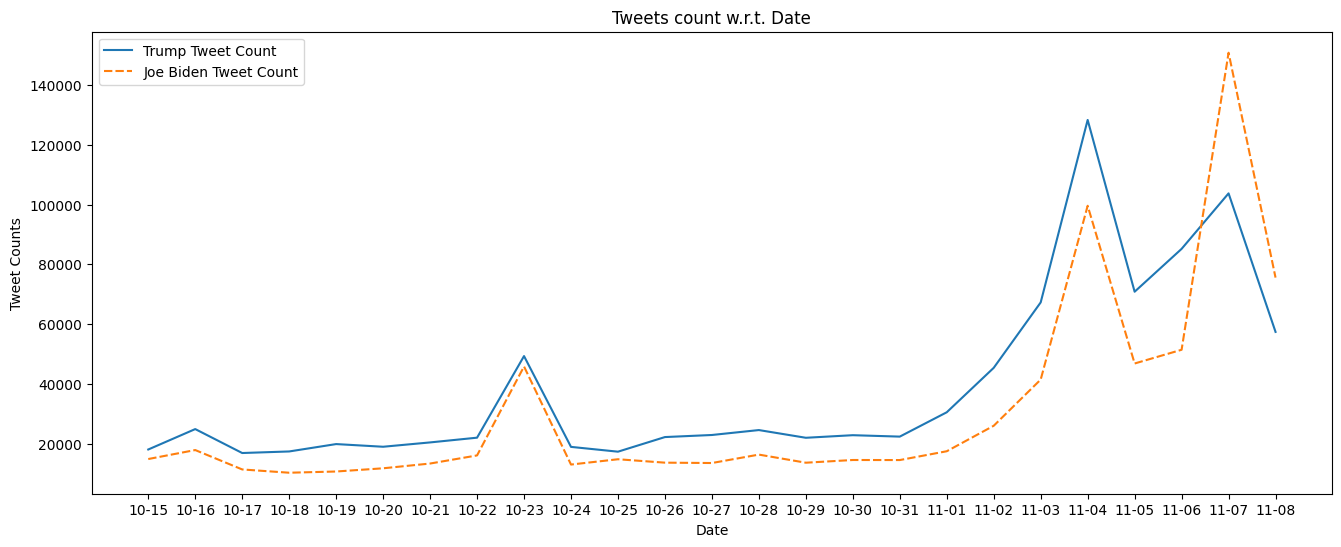

In [60]:
plt.figure(figsize=(16,6))

snb.lineplot(data=overall_df) ; 
plt.title("Tweets count w.r.t. Date")
plt.ylabel("Tweet Counts")

In [61]:
overal_df_likes = pd.DataFrame(columns=['Date' , 'Trump Likes', 'Joe Biden Likes']) ; 
overal_df_likes["Date"] = trump_tweets_by_date_sum.index ; 
overal_df_likes["Trump Likes"] = list(trump_tweets_by_date_sum.likes) ;
overal_df_likes["Joe Biden Likes"] = list(joe_tweets_by_date_sum.likes) ; 

overal_df_likes.set_index('Date' , inplace=True) ;

Text(0, 0.5, 'Likes Counts')

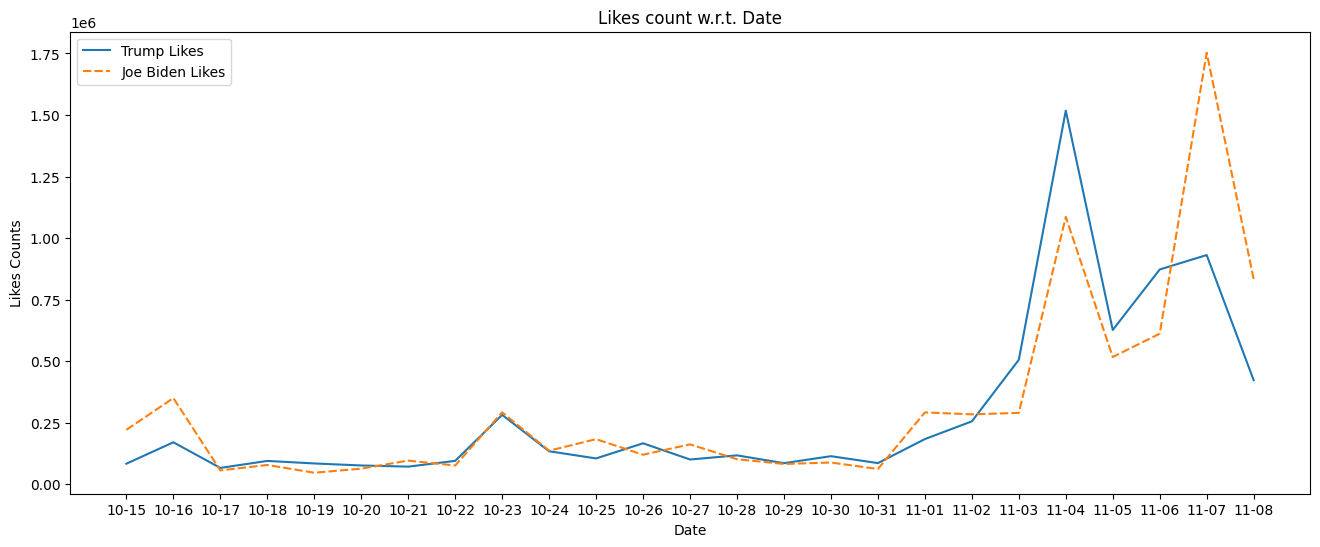

In [62]:
plt.figure(figsize=(16,6))

snb.lineplot(data=overal_df_likes)

plt.title("Likes count w.r.t. Date")
plt.ylabel("Likes Counts")

In [63]:
retweet_df = pd.DataFrame(columns=['Date' , 'Trump Retweet Count', 'Joe Biden Retweet Count']) ; 
retweet_df['Date'] = trump_tweets_by_date_sum.index ; 
retweet_df['Trump Retweet Count'] = list(trump_tweets_by_date_sum.retweet_count) ; 
retweet_df['Joe Biden Retweet Count'] = list(joe_tweets_by_date_sum.retweet_count) ; 


retweet_df.set_index('Date' , inplace=True) ; 

Text(0, 0.5, 'Retweets Counts')

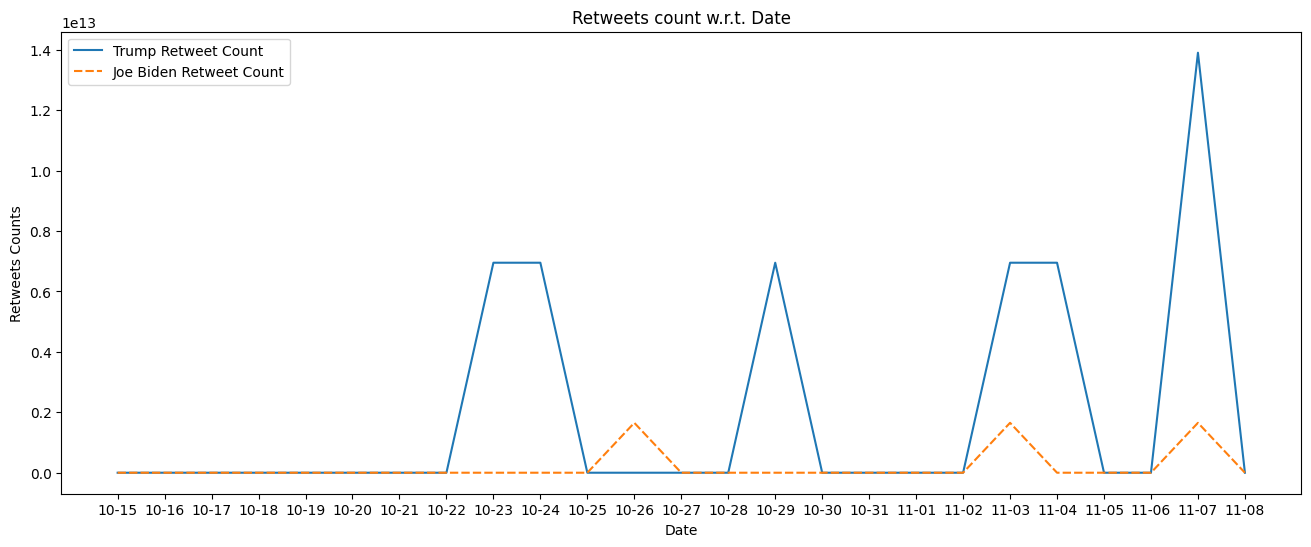

In [64]:
plt.figure(figsize=(16,6))

snb.lineplot(data=retweet_df)

plt.title("Retweets count w.r.t. Date")
plt.ylabel("Retweets Counts")

Word Cloud Of Donald Trump and Joe Biden Tweets

Text(0.5, 1.0, 'Trump Tweets Word Cloud')

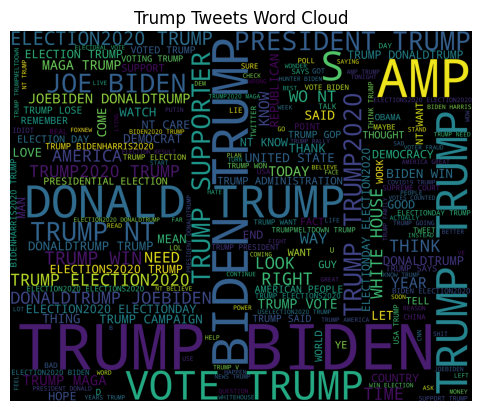

In [65]:
stopwords = set(STOPWORDS) ; 
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_tweet_trump['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Trump Tweets Word Cloud")

Text(0.5, 1.0, 'Joe Biden Tweets Word Cloud')

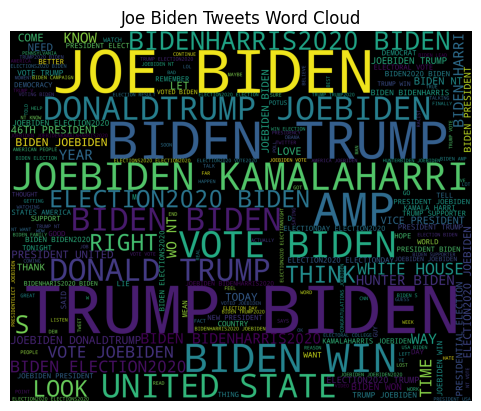

In [66]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_joebiden_tweets['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Joe Biden Tweets Word Cloud")

Building a Model

First of all we have extracted features from tweets using HashVectorizer and then we have splitted our training data in 80-20 ratio. We have tried different algorithms but due huge dataset including huge number of features and rows, very limited number of algorithms worked quickly.  Among these two LogisticRegression had given us 77% of accuracy and Naive Bayessian gave 50% of accuracy. So we have selected LogisticRegression. Once our model is trainned we used this model to find the sentiments of the tweets of both the participants

In [67]:
def train_model(train_data, targets):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)

    model = Pipeline([('vect', HashingVectorizer()),
                      ('logreg', LogisticRegression(max_iter=1000, solver="saga")),
              ])
    model.fit(X_train, Y_train)

    return model, X_test, Y_test

In [68]:
def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [69]:
train_data = english_train_data['text']

In [70]:
targets = english_train_data["label"]

In [71]:
model, x_test, y_test = train_model(train_data, targets)

In [72]:

check_model_metrics(model, x_test, y_test) # basic modelling to get the polarity for now , we will do better moving forward . 

ACCURACY:
77.96710721466003

CONFUSSION MATRIX
[[116208  36669]
 [ 30181 120352]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.76      0.78    152877
           4       0.77      0.80      0.78    150533

    accuracy                           0.78    303410
   macro avg       0.78      0.78      0.78    303410
weighted avg       0.78      0.78      0.78    303410



In [73]:
def get_sentiments(model, data, level_of_signifence):
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_signifence and dif <= level_of_signifence:
            sentiments.append("Neutral")
        elif dif > level_of_signifence:
            sentiments.append("Positive")
        else:
            sentiments.append("Negative")
            
    return sentiments, polarity

In [74]:
trump_tweets_data = eng_tweet_trump["tweet"]


In [75]:
trump_sentiments, tump_polarity = get_sentiments(model, trump_tweets_data, 0.1)


In [76]:
joe_tweets_data = eng_joebiden_tweets["tweet"]


In [77]:
joe_sentiments, joe_polarity = get_sentiments(model, joe_tweets_data, 0.1)


Presentation Of Final Results

After sentiments of Donald Trump and Joe Biden Tweets are determined, we have shown that Joe Biden had won the elections 2020 according to the sentiments in tweets also. First we have analyzed sentiments counts w.r.t. Country and states of both the participants. Then we have analyzed Average polarity w.r.t. Date of both the participants. Then we have analyzed Sentiment count w.r.t. Date of both the participants. Then we have analyzed likes of the sentiments w.r.t. Date of both the participants. Then we have analyzed Sentiment retweets w.r.t. Date of both the participants. Lastly we have shown the pie chart of the percentage of positive, neutral and negative tweets of both the participants.

In [78]:
pd.Series(trump_sentiments).value_counts(normalize=True)


Positive    0.605465
Negative    0.258753
Neutral     0.135783
Name: proportion, dtype: float64

In [79]:
pd.Series(joe_sentiments).value_counts(normalize=True)


Positive    0.630657
Negative    0.227810
Neutral     0.141533
Name: proportion, dtype: float64

In [80]:
eng_tweet_trump["sentiments"] = trump_sentiments
eng_tweet_trump["polarity"] = tump_polarity

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\148590634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["sentiments"] = trump_sentiments
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\148590634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["polarity"] = tump_polarity


In [81]:
eng_joebiden_tweets["sentiments"] = joe_sentiments
eng_joebiden_tweets["polarity"] = joe_polarity

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3330981524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["sentiments"] = joe_sentiments
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3330981524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["polarity"] = joe_polarity


In [82]:
frame = (eng_tweet_trump["country"].value_counts(normalize=True)*100).to_frame()

print(frame)

                          proportion
country                             
United States of America   49.091456
United Kingdom              9.802333
United States               9.420563
India                       4.746034
Canada                      4.556377
...                              ...
Madagascar                  0.000307
Northern Mariana Islands    0.000307
Gabon                       0.000307
Antigua and Barbuda         0.000307
Samoa                       0.000307

[182 rows x 1 columns]


In [83]:
trump_countries = frame[frame.iloc[:, 0] >= 1].index


In [84]:
trump_countrywise_tweets = eng_tweet_trump[eng_tweet_trump["country"].isin(trump_countries)][["country","sentiments","tweet"]]

In [85]:
trump_countrywise_tweets_count = trump_countrywise_tweets.groupby(["country", "sentiments"]).count()

In [86]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_countrywise_sentiments["country"] = trump_countries
df_trump_countrywise_sentiments["Positive Tweets Count"] = [0]*len(trump_countries)
df_trump_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(trump_countries)
df_trump_countrywise_sentiments["Negative Tweets Count"] = [0]*len(trump_countries)

for item in trump_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":
    
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Positive Tweets Count'] = trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Negative Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Neutral Tweets Count']= trump_countrywise_tweets_count.tweet[i]
  i+=1



df_trump_countrywise_sentiments.set_index("country", inplace=True)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\1054413690.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Negative Tweets Count']= trump_countrywise_tweets_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\1054413690.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_trump_countrywise_sentiments.loc[df_trump_countrywise_sentiments.country == country, 'Neutral Tweets Count']= trump_countrywise_tweets_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\1054413690.py:17: FutureWarning: Ser

In [87]:
pp = (df_trump_countrywise_sentiments["Positive Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_countrywise_sentiments["Neutral Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_countrywise_sentiments["Negative Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] +df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

df_trump_countrywise_sentiments["Positive Tweets Count"] = pp

df_trump_countrywise_sentiments["Neutral Tweets Count"] = nup

df_trump_countrywise_sentiments["Negative Tweets Count"] = np  

In [88]:
frame = (eng_joebiden_tweets["country"].value_counts(normalize=True)*100).to_frame()


In [89]:
joe_contries = frame[frame.iloc[:, 0] >= 1].index


In [90]:
joe_countrywise_tweets = eng_joebiden_tweets[eng_joebiden_tweets["country"].isin(joe_contries)][["country","sentiments","tweet"]]  

In [91]:
joe_countrywise_tweets_count = joe_countrywise_tweets.groupby(["country", "sentiments"]).count()


In [92]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_countrywise_sentiments= pd.DataFrame(columns=["country", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_countrywise_sentiments["country"] = joe_contries
df_joe_countrywise_sentiments["Positive Tweets Count"] = [0]*len(joe_contries)
df_joe_countrywise_sentiments["Neutral Tweets Count"] = [0]*len(joe_contries)
df_joe_countrywise_sentiments["Negative Tweets Count"] = [0]*len(joe_contries)

for item in joe_countrywise_tweets_count.index:
  country = item[0]
  if item[1] == "Positive":
    
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Positive Tweets Count'] = joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Negative":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Negative Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Neutral Tweets Count']= joe_countrywise_tweets_count.tweet[i]
  i+=1



df_joe_countrywise_sentiments.set_index("country", inplace=True)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\325203179.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Negative Tweets Count']= joe_countrywise_tweets_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\325203179.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_joe_countrywise_sentiments.loc[df_joe_countrywise_sentiments.country == country, 'Neutral Tweets Count']= joe_countrywise_tweets_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\325203179.py:17: FutureWarning: Series.__getitem__

In [93]:
pp = (df_joe_countrywise_sentiments["Positive Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_countrywise_sentiments["Neutral Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_countrywise_sentiments["Negative Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

df_joe_countrywise_sentiments["Positive Tweets Count"] = pp

df_joe_countrywise_sentiments["Neutral Tweets Count"] = nup

df_joe_countrywise_sentiments["Negative Tweets Count"] = np

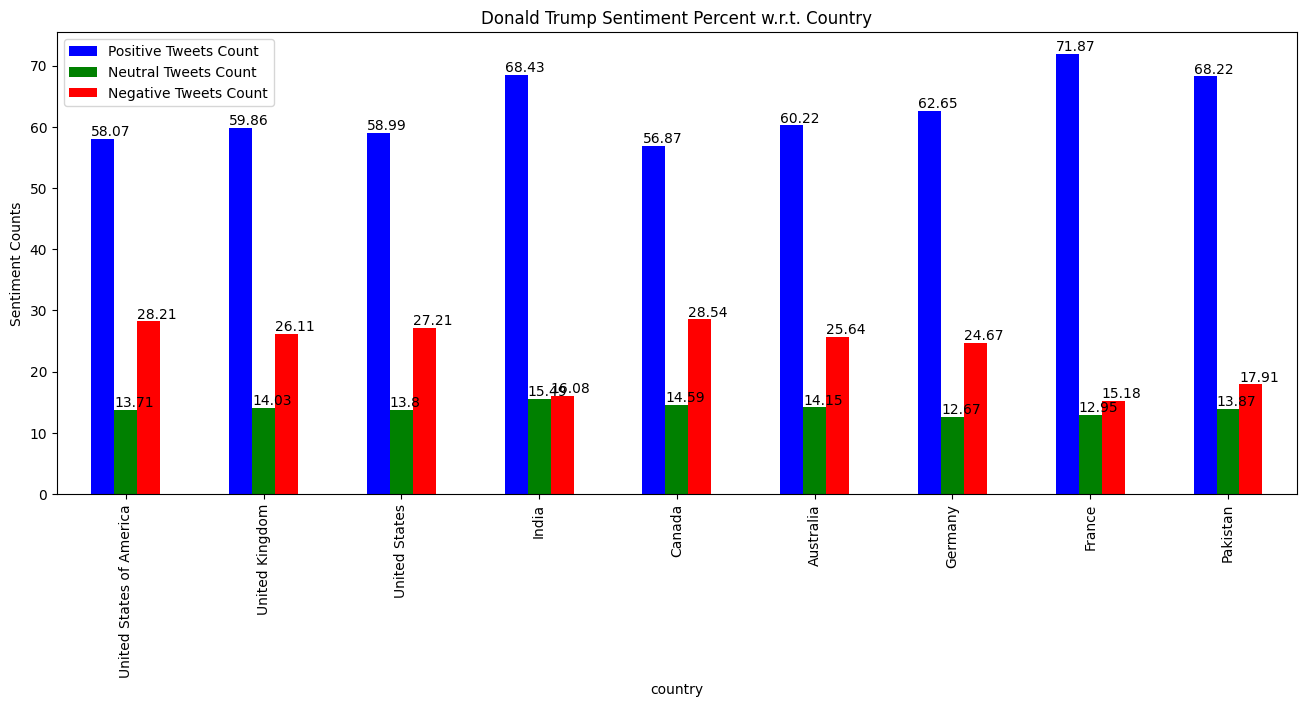

In [94]:
plot = df_trump_countrywise_sentiments.plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")
for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

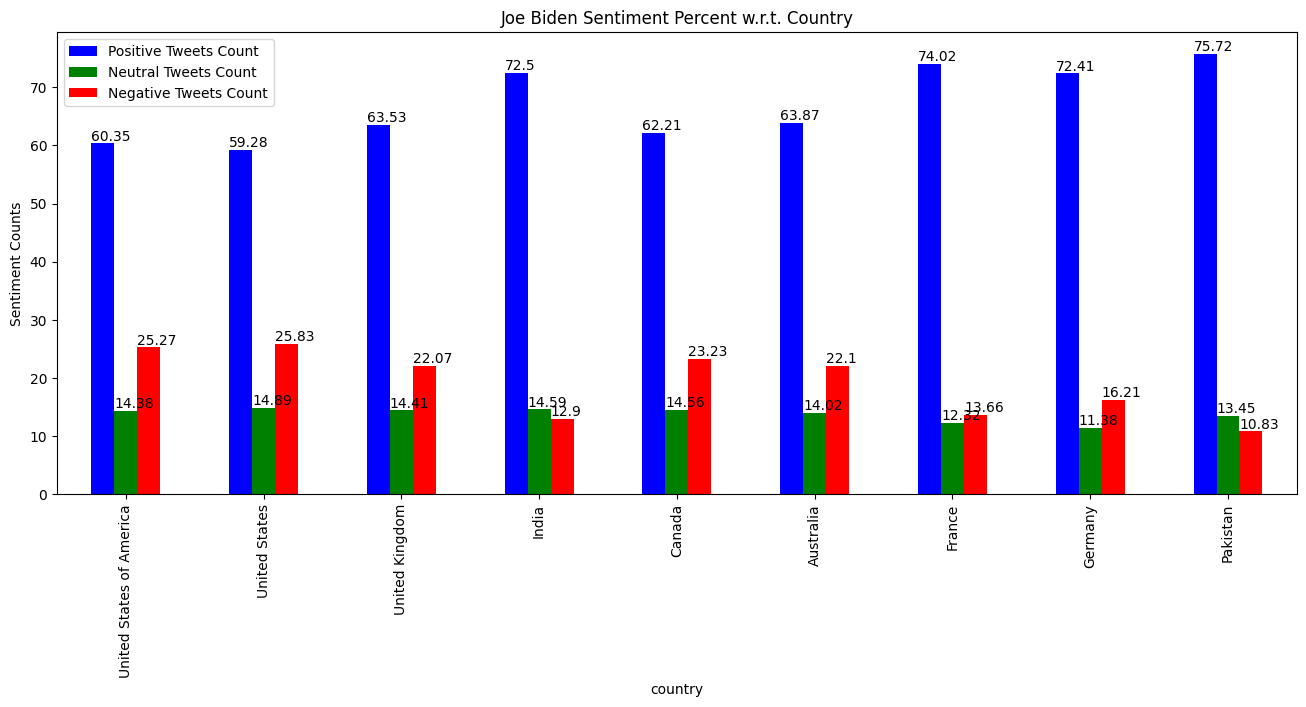

In [95]:
plot = df_joe_countrywise_sentiments.plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])
plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [96]:
trump_US_tweets = pd.concat([eng_tweet_trump[eng_tweet_trump["country"] == "United States of America"], eng_tweet_trump[eng_tweet_trump["country"] == "United States"]])

joe_US_tweets = pd.concat([eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States of America"], eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States"]])

In [97]:
frame = (trump_US_tweets["state"].value_counts(normalize=True)*100).to_frame()
trump_states = frame[frame.iloc[:, 0] >= 1].index

trump_US_tweets = trump_US_tweets[trump_US_tweets["state"].isin(trump_states)]

In [98]:
frame = (joe_US_tweets["state"].value_counts(normalize=True)*100).to_frame()
joe_states = frame[frame.iloc[:, 0] >= 1].index

joe_US_tweets = joe_US_tweets[joe_US_tweets["state"].isin(joe_states)]

In [99]:
trump_US_tweets_groupby_state_sent = trump_US_tweets.groupby(["state", "sentiments"])

joe_US_tweets_groupby_state_sent = joe_US_tweets.groupby(["state", "sentiments"])

In [100]:
trump_US_tweets_groupby_state_sent_count = trump_US_tweets_groupby_state_sent.count()

joe_US_tweets_groupby_state_sent_count = joe_US_tweets_groupby_state_sent.count()

In [101]:
us_trump_states = trump_US_tweets_groupby_state_sent_count.index.to_frame()["state"].unique()

us_joe_states = joe_US_tweets_groupby_state_sent_count.index.to_frame()["state"].unique()

In [102]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_trump_statewise_sentiments= pd.DataFrame(columns=["State", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_trump_statewise_sentiments["State"] = us_trump_states
df_trump_statewise_sentiments["Positive Tweets Count"] = [0]*len(us_trump_states)
df_trump_statewise_sentiments["Neutral Tweets Count"] = [0]*len(us_trump_states)
df_trump_statewise_sentiments["Negative Tweets Count"] = [0]*len(us_trump_states)

for item in trump_US_tweets_groupby_state_sent_count.index:
  state = item[0]
  if item[1] == "Positive":
    
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Positive Tweets Count'] = trump_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Negative":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Negative Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Neutral":
    df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Neutral Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
  i+=1


pp = (df_trump_statewise_sentiments["Positive Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_trump_statewise_sentiments["Neutral Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_trump_statewise_sentiments["Negative Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] +df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

df_trump_statewise_sentiments["Positive Tweets Count"] = pp

df_trump_statewise_sentiments["Neutral Tweets Count"] = nup

df_trump_statewise_sentiments["Negative Tweets Count"] = np


df_trump_statewise_sentiments.set_index("State", inplace=True)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\2782168553.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Negative Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\2782168553.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_trump_statewise_sentiments.loc[df_trump_statewise_sentiments.State == state, 'Neutral Tweets Count']= trump_US_tweets_groupby_state_sent_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\2782168553.py:17: FutureWarning:

In [103]:
positive_tweets = []
neutral_tweets = []
negative_tweets = []
i = 0

df_joe_statewise_sentiments= pd.DataFrame(columns=["State", "Positive Tweets Count", "Neutral Tweets Count", "Negative Tweets Count"])

df_joe_statewise_sentiments["State"] = us_joe_states
df_joe_statewise_sentiments["Positive Tweets Count"] = [0]*len(us_joe_states)
df_joe_statewise_sentiments["Neutral Tweets Count"] = [0]*len(us_joe_states)
df_joe_statewise_sentiments["Negative Tweets Count"] = [0]*len(us_joe_states)

for item in joe_US_tweets_groupby_state_sent_count.index:
  state = item[0]
  if item[1] == "Positive":
    
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Positive Tweets Count'] = joe_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Negative":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Negative Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
  if item[1] == "Neutral":
    df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Neutral Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
  i+=1


pp = (df_joe_statewise_sentiments["Positive Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

nup = (df_joe_statewise_sentiments["Neutral Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

np = (df_joe_statewise_sentiments["Negative Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

df_joe_statewise_sentiments["Positive Tweets Count"] = pp

df_joe_statewise_sentiments["Neutral Tweets Count"] = nup

df_joe_statewise_sentiments["Negative Tweets Count"] = np

df_joe_statewise_sentiments.set_index("State", inplace=True)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3144739223.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Negative Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3144739223.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_joe_statewise_sentiments.loc[df_joe_statewise_sentiments.State == state, 'Neutral Tweets Count']= joe_US_tweets_groupby_state_sent_count.tweet[i]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18848\3144739223.py:17: FutureWarning: Series.__ge

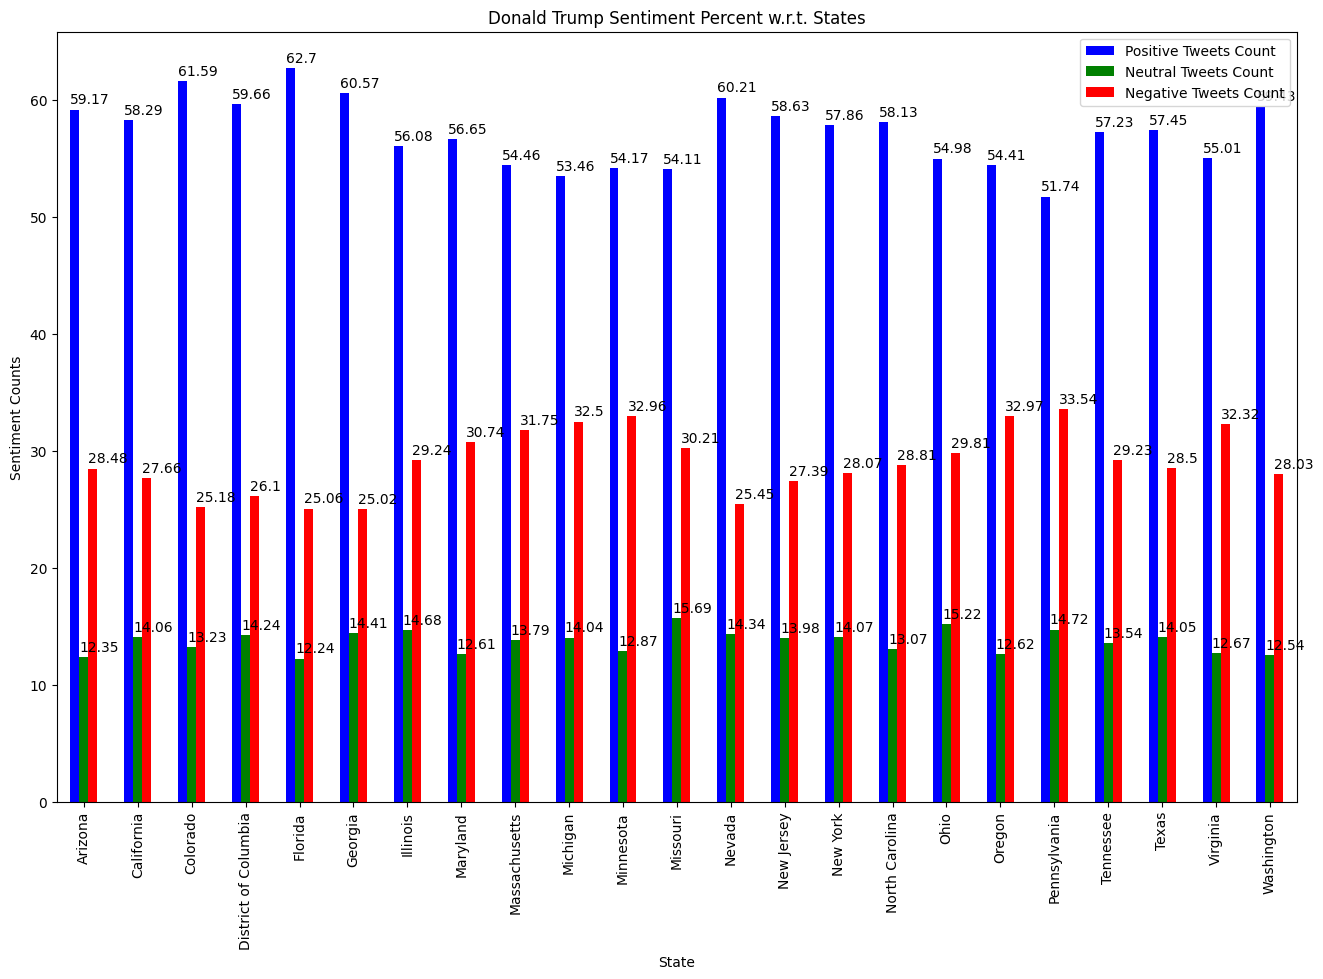

In [104]:
plot = df_trump_statewise_sentiments.plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. States")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

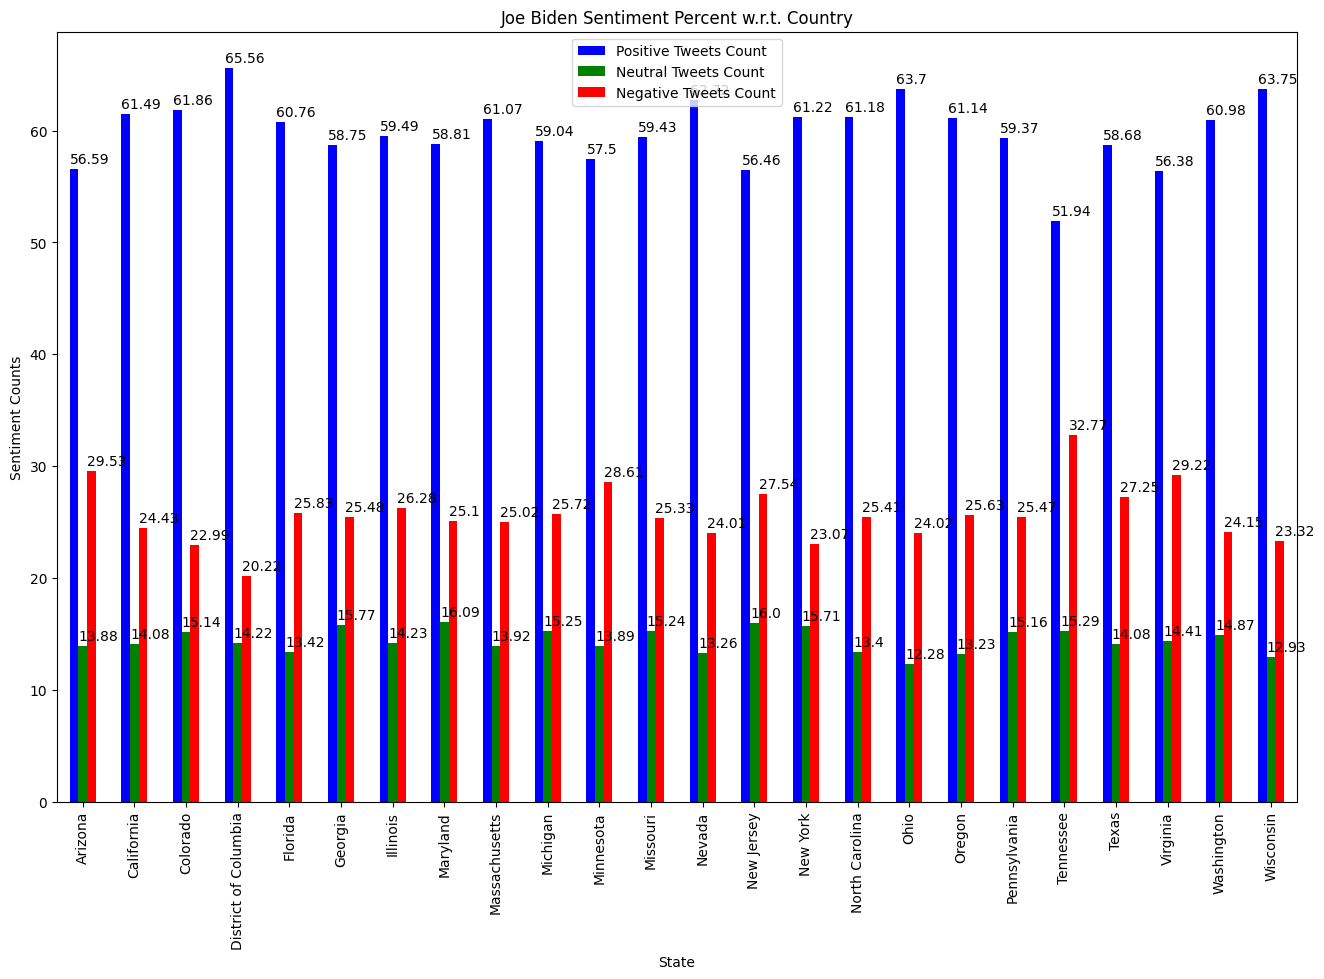

In [105]:
plot = df_joe_statewise_sentiments.plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

In [106]:
trump_US_tweets_groupby_date = trump_US_tweets.groupby("created_at")

joe_US_tweets_groupby_date = joe_US_tweets.groupby("created_at")

# First Hypothesis (Z-TEST ON POLARITY OF JOE BIDEN) . 

H0 = Average polarity of Joe Biden is greater than overall average polarity    
H1 = Average polarity of Joe Biden is lesser than overall average polarity

In [107]:
# we get all the polarity using the csv files of trump and joe biden tweets. 

all_polarity = pd.concat([eng_tweet_trump["polarity"], eng_joebiden_tweets["polarity"]])

In [108]:
sample = eng_joebiden_tweets["polarity"].sample(n=50)


In [109]:
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

sample mean:  0.6072513475001119 , population mean:  0.5810485555861566 , sigma:  0.2011606626975048 , n:  50


In [110]:
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)


Z calculated value is:  0.9210633729239358


Alpha = 0.05 Z_tabular = 1.65 (we are considerinng 5% confidence interval) . 

As,

Z_calc < Z_tabular

So H0 is accepted and Average polarity of Joe Biden is greater than overall average polarity.


# Second Hypothesis

Ho = Sentiments of Joe Biden is Independent or not related to states 

H1 = Sentiments of Joe Biden is dependent or related to states

In [111]:
chiObservedData = pd.crosstab(joe_US_tweets["sentiments"], joe_US_tweets["state"])



In [112]:
chiObservedData

state,Arizona,California,Colorado,District of Columbia,Florida,Georgia,Illinois,Maryland,Massachusetts,Michigan,...,New York,North Carolina,Ohio,Oregon,Pennsylvania,Tennessee,Texas,Virginia,Washington,Wisconsin
sentiments,,,,,,,,,,,,,,,,,,,,,
Negative,804,5424,536,1126,2722,711,1269,457,773,683,...,4128,675,802,521,1183,566,3351,582,450,330
Neutral,378,3125,353,792,1414,440,687,293,430,405,...,2812,356,410,269,704,264,1731,287,277,183
Positive,1541,13649,1442,3651,6404,1639,2872,1071,1887,1568,...,10954,1625,2127,1243,2757,897,7216,1123,1136,902


We get r = 3 and c = 24 here 

In [113]:
stat, p, ddof, expected = chi2_contingency(chiObservedData)


In [114]:
stat, p, ddof, expected


(380.68938733797273,
 3.0654136484476526e-54,
 46,
 array([[  683.45034741,  5571.51333522,   585.06160845,  1397.77267158,
          2645.45231792,   700.26679004,  1211.78783595,   457.05585113,
           775.56429434,   666.63390478,   363.18496243,   380.50338842,
           488.17881958,   854.87766554,  4491.24514012,   666.63390478,
           838.06122292,   510.26608751,  1165.60536664,   433.46263312,
          3086.69569315,   499.97542859,   467.59750173,   355.15322864],
        [  392.97928393,  3203.58213175,   336.40643072,   803.70974375,
          1521.11702264,   402.64862364,   696.76973295,   262.80399414,
           445.94417457,   383.30994423,   208.82887398,   218.7868507 ,
           280.69948852,   491.54882155,  2582.43529442,   383.30994423,
           481.87948184,   293.3995168 ,   670.21512838,   249.23805485,
          1774.82895109,   287.48245817,   268.86537127,   204.21068188],
        [ 1646.57036866, 13422.90453303,  1409.53196083,  3367.51758467

In [115]:
chi_value, p_value = chisquare(chiObservedData, expected)


In [116]:
chi_value, p_value


(array([28.60266623,  9.64154481,  5.68055022, 76.876045  ,  9.9047511 ,
         4.99986871,  3.6091088 ,  4.29449739,  0.76187933,  2.53090725,
         9.51510439,  0.98311595,  4.3914558 , 22.95093524, 51.43736069,
         2.27421026, 18.04418903,  2.40680625,  2.89540049, 62.17620443,
        30.25052968, 18.97756794,  0.98786626,  6.49682207]),
 array([6.15190958e-07, 8.06055871e-03, 5.84095946e-02, 2.02571775e-17,
        7.06660189e-03, 8.20903873e-02, 1.64547763e-01, 1.16805083e-01,
        6.83219111e-01, 2.82111295e-01, 8.58660201e-03, 6.11672680e-01,
        1.11277533e-01, 1.03816823e-05, 6.76891473e-12, 3.20746197e-01,
        1.20713026e-04, 3.00170953e-01, 2.35110363e-01, 3.15216363e-14,
        2.69886364e-07, 7.56960962e-05, 6.10221588e-01, 3.88358676e-02]))

In [117]:
print("Chi-Square Calculated Value:",  chi_value.sum())


Chi-Square Calculated Value: 380.68938733797273


In [118]:
alpha = 0.05
prob = 1 - alpha
critical_value = chi2.ppf(prob, ddof)
print("Critcal Value: ", critical_value)

Critcal Value:  62.82962041140818


In [119]:
p<alpha

True

we have chi-square-value > critical_value p_value < alpha also , thus we reject the Ho which mean Sentiments of Joe Biden is dependent or related to states

# Third Hypothesis

H0 = Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

Ha = Average polarity among high profile users of Joe Biden is lesser than overall average polarity among high profile users.

In [120]:
joe_high_profile_user_tweets = joe_US_tweets[joe_US_tweets["user_followers_count"] > 100000]


In [121]:
print("No. of high profile users in US tweeted for Joe Biden: ", len(joe_high_profile_user_tweets["user_id"].unique()))

No. of high profile users in US tweeted for Joe Biden:  246


In [122]:
trump_high_profile_user_tweets = trump_US_tweets[trump_US_tweets["user_followers_count"] > 100000]

In [123]:
print("No. of high profile users in US tweeted for Donald Trump: ", len(trump_high_profile_user_tweets["user_id"].unique()))

No. of high profile users in US tweeted for Donald Trump:  197


In [124]:
all_polarity_high_profile_users = pd.concat([trump_high_profile_user_tweets["polarity"], joe_high_profile_user_tweets["polarity"]])

In [125]:
sample_joe_high_profile_users = joe_high_profile_user_tweets["polarity"].sample(n=50)


In [126]:
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

sample mean:  0.6072513475001119 , population mean:  0.5810485555861566 , sigma:  0.2011606626975048 , n:  50


In [127]:
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)

Z calculated value is:  0.9210633729239358


Alpha = 0.05 Z_tabular = 1.65

Z_calc < Z_tabular

So H0 is accepted and Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

# Fourth Hypothesis 

F Test


Null Hypothesis  H0 : Variance of number of likes for the Joe Biden Population and Trump Population is Same

Alternative Hypothesis : Variance of number of likes for the Joe Biden Population and Trump Population is not Same

In [128]:
import scipy.stats as stats
data1 = eng_tweet_trump["likes"].sample(n=50)
data2 = eng_joebiden_tweets["likes"].sample(n=50)
#print("data 1", data1)
print(data1.isnull().sum())
#data1= np.array(data1)
var1 = data1.var(ddof=1) 
var2= data2.var(ddof=1)

f_statistic = var1 / var2  # F-statistic


df1 = len(data1) - 1  
df2 = len(data2) - 1  


p_value = 1 - stats.f.cdf(f_statistic, df1, df2)  

print("F-statistic:", f_statistic)
print("p-value:", p_value)

# checking  if we can reject the null hypothesis
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: Variances are not significantly different.")

0
F-statistic: 42.1480144404332
p-value: 1.1102230246251565e-16
Reject the null hypothesis: Variances are significantly different.


# FIFTH HYPOTHESIS

Z-test for two proportions : Proportion Test on Positive/Negative Sentiments (Sentiment Ratio)

Goal: Compare the proportion of positive sentiments between Biden and Trump tweets to see if there is a significant difference in the positivity rate.

H0 : There is no significant difference in the proportion of positive sentiments in Trump and Biden tweets
H1 : There is significant difference in the proportion of positive sentiments in Trump and Biden tweets

In [129]:
alpha = 0.05
z_tab = 1.96  # 95% confidence level 
biden_pos = eng_joebiden_tweets[eng_joebiden_tweets["sentiments"] == "Positive"].shape[0]
trump_pos = eng_tweet_trump[eng_tweet_trump["sentiments"] == "Positive"].shape[0]
tot_biden = eng_joebiden_tweets.shape[0]
tot_trump = eng_tweet_trump.shape[0]

p1 = biden_pos / tot_biden  
p2 = trump_pos / tot_trump  

P = (p1* tot_biden + p2 * tot_trump) / (tot_biden + tot_trump)

#formula from class slides
z_cal = (p1 - p2) / math.sqrt(P * (1 - P) * (1 / tot_biden + 1 / tot_trump))

print("Z-statistic:", z_cal)

if abs(z_cal) > z_tab:
    print("Reject H0 : There is a significant difference in positive sentiment proportions.")
else:
    print("Fail to reject H0 : No significant difference in positive sentiment proportions.")


Z-statistic: 28.167746463208267
Reject H0 : There is a significant difference in positive sentiment proportions.


# 1. Which  ML modeling is used to solve your problem statement? Describe the running time and accuracy of the model on test or train data in 2-3 slides.

ML MODEL USED TO SOLVE THE PROBLEM IS AS FOLLOWS : 


In [166]:
def train_model(train_data, targets):
    vectorizer = HashingVectorizer()
    X_transformed = vectorizer.transform(train_data)

    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, targets, test_size=0.2)

    model = LogisticRegression(max_iter=1000, solver="saga")
    
    start_time = time.time()  
    model.fit(X_train, Y_train)
    end_time = time.time() 

    training_time = end_time - start_time
    print(f"Training time for Logistic Regression without JL Lemma: {training_time:.4f} seconds")

    return model, X_test, Y_test

In [167]:
def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [168]:
train_data = english_train_data['text']
targets = english_train_data["label"]
print(train_data)
model, x_test, y_test = train_model(train_data, targets)
check_model_metrics(model, x_test, y_test) # basic modelling to get the polarity for now , we will do better mobing forward . 



0          upset nt update facebook texting cry result   ...
1             dived times ball managed save 50   rest bounds
2                               body feels itchy like fire  
3                                        behaving m mad nt  
4                                                     crew  
                                 ...                        
1599994                    woke having school best feeling  
1599995        thewdbcom   cool hear old walt interviews    
1599996                    ready mojo makeover ask details  
1599997    happy 38th birthday boo al time tupac amaru sh...
1599998                                 happy charitytuesday
Name: text, Length: 1517046, dtype: object
Training time for Logistic Regression without JL Lemma: 25.7352 seconds
ACCURACY:
77.76441119277546

CONFUSSION MATRIX
[[116087  36663]
 [ 30802 119858]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    152750


# 2. Use any randomized scaling techniques taught in the class to scale up the training phase of your model. Give a reason for the used method and show a comparison of the test/train accuracy from a model trained on the smaller dataset vs a model trained on the actual dataset in 3-5 slides.

In [169]:
def check_data_size(train_data , targets):
    X_train , X_test , Y_train , Y_test = train_test_split(train_data, targets, test_size=0.2) ; 
    
    vectorizer = HashingVectorizer() ; 
    
    X_train_vectorized = vectorizer.fit_transform(X_train) ; 
    
    return X_train_vectorized.shape ;  
        
    
    
train_data = english_train_data['text']
targets = english_train_data["label"]
print(f"The shape of the data after HashingVectorization is: {check_data_size(train_data, targets)}" ) ; 

The shape of the data after HashingVectorization is: (1213636, 1048576)


APPLYING JL LEMMA TO THE DATASET FOR SIGNIFICANT REDUCTION IN TIME (RANDOMIZED SCALING TECHNIQUE - 1) . 

In [174]:
def train_model(train_data, targets, n_components=1000):

    vectorizer = HashingVectorizer()
    X_transformed = vectorizer.transform(train_data)
    projector = SparseRandomProjection(n_components=n_components)
    X_projected = projector.fit_transform(X_transformed)

 
    X_train, X_test, Y_train, Y_test = train_test_split(X_projected, targets, test_size=0.2)

    model = LogisticRegression(max_iter=1000, solver="saga")
    
    start_time = time.time() 
    model.fit(X_train, Y_train)
    end_time = time.time() 

    training_time = end_time - start_time
    print(f"Training time for Logistic Regression only: {training_time:.4f} seconds")

    return model, X_test, Y_test

In [175]:
train_data = english_train_data['text']
targets = english_train_data["label"]
print(train_data)
model, x_test, y_test = train_model(train_data, targets)
check_model_metrics(model, x_test, y_test) # basic modelling to get the polarity for now , we will do better mobing forward . 


0          upset nt update facebook texting cry result   ...
1             dived times ball managed save 50   rest bounds
2                               body feels itchy like fire  
3                                        behaving m mad nt  
4                                                     crew  
                                 ...                        
1599994                    woke having school best feeling  
1599995        thewdbcom   cool hear old walt interviews    
1599996                    ready mojo makeover ask details  
1599997    happy 38th birthday boo al time tupac amaru sh...
1599998                                 happy charitytuesday
Name: text, Length: 1517046, dtype: object
Training time for Logistic Regression only: 19.5762 seconds
ACCURACY:
67.74397679707327

CONFUSSION MATRIX
[[ 99392  53595]
 [ 44273 106150]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.69      0.65      0.67    152987
           4